In [1]:
import os
import re
import math
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get the user's home directory (e.g., 'C:\Users\user')
DATA_DIR = r"C:\Users\ferit\MLPC2025_dataset"

In [3]:
# Load metadata
metadata = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata.set_index('filename', inplace=True)

In [4]:
# Load annotations 
annotations = pd.read_csv(os.path.join(DATA_DIR, "annotations.csv"))

In [5]:
# Load annotations embeddings
annotations_embeddings = np.load(os.path.join(DATA_DIR, "annotations_text_embeddings.npz"))["embeddings"]
print(annotations_embeddings.shape)

(35826, 1024)


#### Preprocessing Audio Features

In [6]:
# High computational effort!!!

In [7]:
# Loading the Audio Features
audio_features = {}
for idx, row in metadata.iterrows():
    path_to_feature_file = os.path.join(DATA_DIR, 'audio_features', idx.replace('mp3', 'npz'))
    audio_features[idx] = np.load(path_to_feature_file)['embeddings']

In [8]:
# Print number of feature files
print(f"{'Number of feature files: ':<30}{len(audio_features)}")

Number of feature files:      9026


In [9]:
# Feature Normalization
concatenated_feature_tensor = np.concatenate(list(audio_features.values()), axis=0)

In [10]:
print(f"{'Shape of all feature tensors concatenated: ':<30}{concatenated_feature_tensor.shape}")

Shape of all feature tensors concatenated: (1684753, 768)


#### Feature Tensor Scaler

In [11]:
# High computational effort!!!

In [12]:
# Compute mean and standard deviation of the Feature Tensor
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(concatenated_feature_tensor)

del concatenated_feature_tensor

#### Audio Feature Extractor for Annotated Regions

In [13]:
import math

def get_features_of_annotation(
    onset: float, 
    offset: float, 
    audio_features: np.ndarray, 
    scaler: preprocessing.StandardScaler = None
) -> np.ndarray:

    RESOLUTION = 0.12 # temporal resolution of the features is 120 ms
    start_idx = math.floor(onset / RESOLUTION)
    offset_idx = math.ceil(offset / RESOLUTION)
    
    audio_features = audio_features[start_idx:offset_idx, :]
    if scaler is not None:
        audio_features = scaler.transform(audio_features)    
    return audio_features.mean(axis=0)

#### Scaled Feature Tensor

In [14]:
# High computational effort!!!

In [15]:
X = np.zeros((len(annotations), 768))
for i, row in annotations.iterrows():
    X[i] = get_features_of_annotation(row['onset'], row['offset'], audio_features[row['filename']], scaler)

In [16]:
print("Audio Features of annotated regions:", X.shape)

Audio Features of annotated regions: (35826, 768)


#### Clustering the Audio Features

In [17]:
# Clustering the Audio Features
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=25, max_iter=300, random_state=14124).fit(X)
clusters = kmeans.predict(X)
annotations['clusters'] = clusters

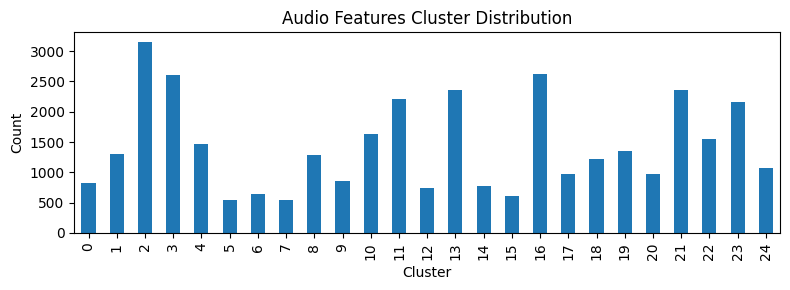

In [18]:
# Plot Audio Features Clustering
counts = annotations["clusters"].value_counts(sort=False).sort_index()
counts.plot(kind="bar", figsize=(8, 3))

plt.title('Audio Features Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Task 4: Text Features

### Task 4 (a): Cluster Text Features

In [19]:
# Compute mean and standard deviation of the Feature Tensor
from sklearn import preprocessing
text_scaler = preprocessing.StandardScaler().fit(annotations_embeddings)

#### Scaled Feature Tensor

In [20]:
# Normalize Text Feature
text_features = text_scaler.transform(annotations_embeddings)

#### PCA Reduced Feature Tensor

In [21]:
# PCA dimensionality reduction with keeping 95% of the variance
pca = PCA(n_components=0.95)
text_reduced = pca.fit_transform(text_features)

In [22]:
# Print PCA dimensionality reduction
print("="*80)
print("Text Feature Analysis")
print("="*80)
print(f"{'Feature shape':<30}: {annotations_embeddings.shape}")

print("\nDimensionality Reduction Results:")
print("-"*80)
print(f"{'Original features':<30}: {annotations_embeddings.shape[1]}")
print(f"{'Reduced features':<30}: {text_reduced.shape[1]}")
print(f"{'Variance explained':<30}: {sum(pca.explained_variance_ratio_):>5.1%}")
print("-"*80)

Text Feature Analysis
Feature shape                 : (35826, 1024)

Dimensionality Reduction Results:
--------------------------------------------------------------------------------
Original features             : 1024
Reduced features              : 131
Variance explained            : 95.0%
--------------------------------------------------------------------------------


#### KMeans Clustering

In [23]:
# KMeans Clustering
kmeans = KMeans(n_clusters=25, max_iter=300, random_state=14124)

# Clustering Text Features
text_df = pd.DataFrame(text_reduced)
text_df['cluster'] = kmeans.fit_predict(text_reduced)

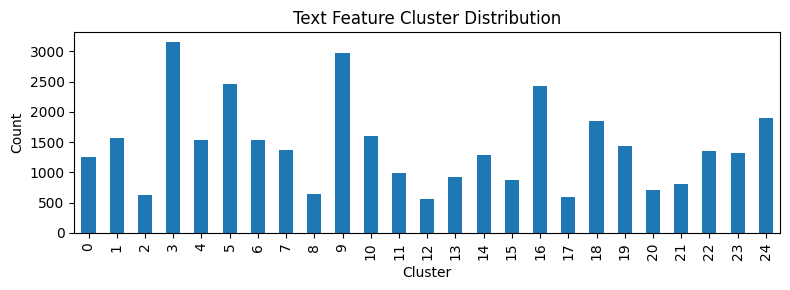

In [24]:
# Plot Text Features Clustering
counts_text = text_df['cluster'].value_counts(sort=False).sort_index()
counts_text.plot(kind='bar', figsize=(8, 3))
plt.title('Text Feature Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### Vizualize Text Feature (PCA with n=2 & K-Means with n=25)

In [25]:
# Dimensionality reduction
n_dim=2
pca = PCA(n_components=n_dim)
X_PC2 = pca.fit_transform(text_features)

In [26]:
# Clustering
n_clusters = 25
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_clusters = kmeans.fit_predict(X_PC2)

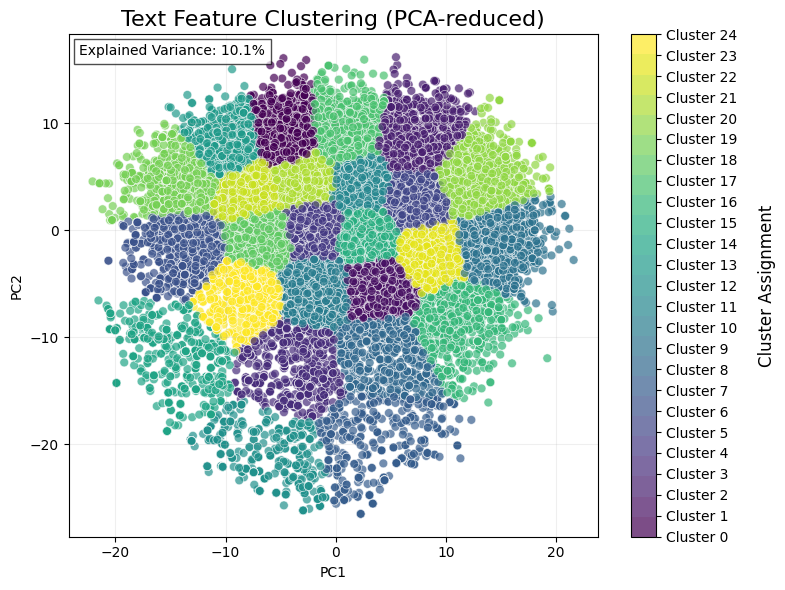

In [27]:
# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.cm.get_cmap('viridis', n_clusters)

# Plot points with cluster colors
scatter = ax.scatter(X_PC2[:, 0], X_PC2[:, 1],c=X_clusters, cmap=cmap,s=40, alpha=0.7, edgecolor='w', linewidth=0.5)

plt.title('Text Feature Clustering (PCA-reduced)', fontsize=16)
plt.xlabel('PC1', fontsize=10)
plt.ylabel('PC2', fontsize=10)
plt.grid(alpha=0.2)

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(n_clusters))
cbar.set_label('Cluster Assignment', fontsize=12, labelpad=15)
cbar.ax.tick_params(labelsize=10)
cbar.set_ticklabels([f'Cluster {i}' for i in range(n_clusters)])

# Add explained variance ratio
plt.text(0.02, 0.98, 
         f"Explained Variance: {pca.explained_variance_ratio_.sum():.1%}",
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

### Task 4 (b): Labeling function

In [28]:
# Dog keywords
def is_dog(text_annotation):
    keywords = ['dog', 'bark', 'woof', 'canine']
    return any([kw in text_annotation for kw in keywords])

In [29]:
# Cat keywords
def is_cat(text_annotation):
    keywords = ['cat', 'meow', 'purr', 'kitten']
    return any([kw in text_annotation for kw in keywords])

In [30]:
# Dog cluster assignment
annotations['dog'] = annotations['text'].transform(is_dog)
annotations['dog'].value_counts()

dog
False    34215
True      1611
Name: count, dtype: int64

In [31]:
# Cat cluster assignment
annotations['cat'] = annotations['text'].transform(is_cat)
annotations['cat'].value_counts()

cat
False    34912
True       914
Name: count, dtype: int64

## Task 4 (c): Audio feature clustering & alignment

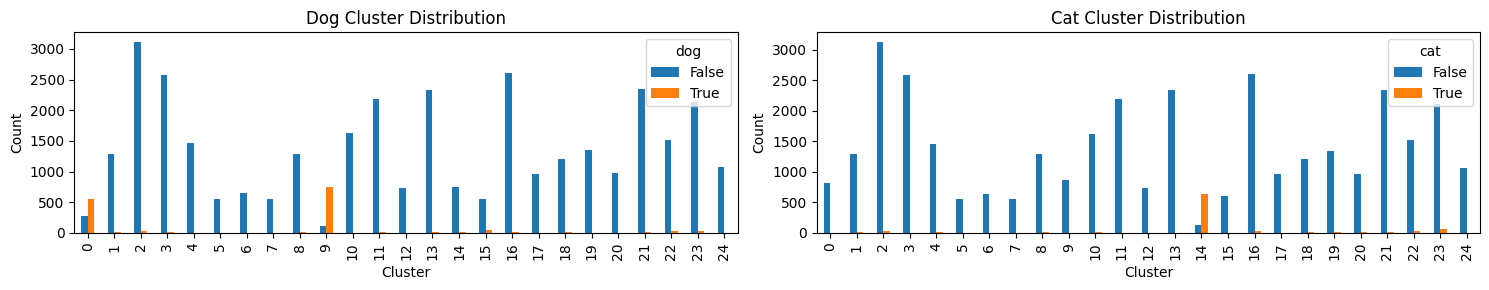

In [32]:
# Plot Dog/Cat Clustering
fig, ax = plt.subplots(1, 2, figsize=(15, 3))

counts = annotations[['clusters', 'dog']].groupby(['clusters', 'dog']).size().unstack()
counts.plot(kind='bar', ax=ax[0])
ax[0].set_title('Dog Cluster Distribution')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Count')

counts = annotations[['clusters', 'cat']].groupby(['clusters', 'cat']).size().unstack()
counts.plot(kind='bar', ax=ax[1])
ax[1].set_title('Cat Cluster Distribution')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [33]:
# Check dog labels in classes
annotations.loc[annotations['clusters'] == 0, 'text'].head(n=5)
annotations.loc[annotations['clusters'] == 9, 'text'].head(n=5)

12     A dog is barking furiously.
58     A noise humming constantly.
62                   A dog barking
94                    A dog growls
110                   dog barking 
Name: text, dtype: object

In [34]:
# Check cat labels in classes
annotations.loc[annotations['clusters'] == 14, 'text'].head(n=5)

3                 A high pitch meowing coming from a cat
27     Continuous purrr like sound which resembles to...
63     opening or closing a zip noise in background, ...
107      Low-pitched cat meow with low background noise.
123       A ball kicking the ground one time, distantly.
Name: text, dtype: object

#### Vizualize Labeled Text Clusters (TSNE with n=2)

In [35]:
# High computational effort!!!

In [36]:
# TSNE Clustering
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)
tsne.shape

(35826, 2)

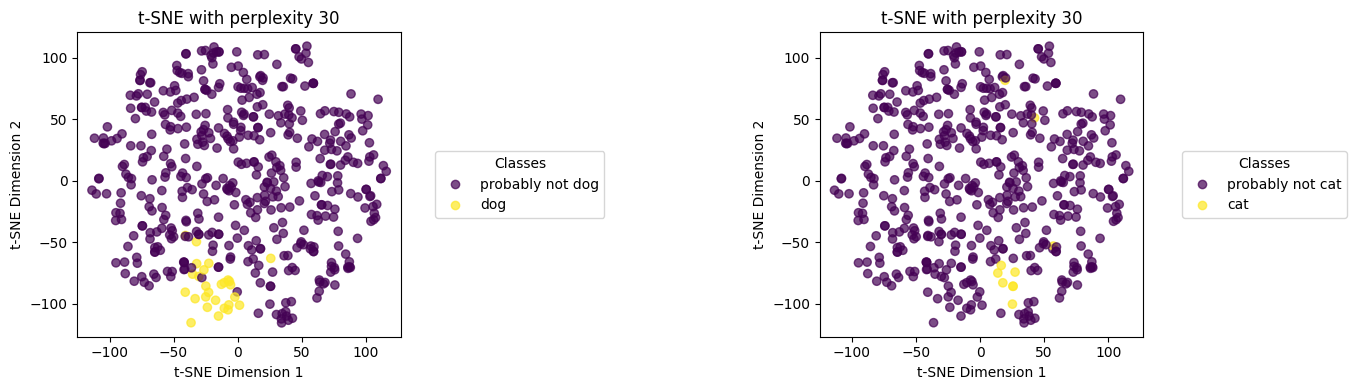

In [37]:
# Visualize Dog/Cat Clustering
np.random.seed(2982)
sample_indices = np.random.choice(len(X), size=min(500, len(X)), replace=False) # Subsample data points to reduce visual clutter
tsne_sampled = tsne[sample_indices]

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

y_dog = annotations["dog"].loc[sample_indices]
scatter = ax[0].scatter(tsne_sampled[:, 0], tsne_sampled[:, 1], c=y_dog, alpha=0.7)
handles, _ = scatter.legend_elements() # Create a legend
ax[0].legend(handles, ['probably not dog', 'dog'], title="Classes", ncol=1, loc='center right', bbox_to_anchor=(1.65, 0.5))
ax[0].set_xlabel("t-SNE Dimension 1")
ax[0].set_ylabel("t-SNE Dimension 2")
ax[0].set_title(f"t-SNE with perplexity 30")

y_cat = annotations["cat"].loc[sample_indices]
scatter = ax[1].scatter(tsne_sampled[:, 0], tsne_sampled[:, 1], c=y_cat, alpha=0.7)
handles, _ = scatter.legend_elements() # Create a legend
ax[1].legend(handles, ['probably not cat', 'cat'], title="Classes", ncol=1, loc='center right', bbox_to_anchor=(1.65, 0.5))
ax[1].set_xlabel("t-SNE Dimension 1")
ax[1].set_ylabel("t-SNE Dimension 2")
ax[1].set_title(f"t-SNE with perplexity 30")

plt.tight_layout()
plt.show()